2025-08-08 21:01:23 INFO     Fetching BTC price data from GitHub...


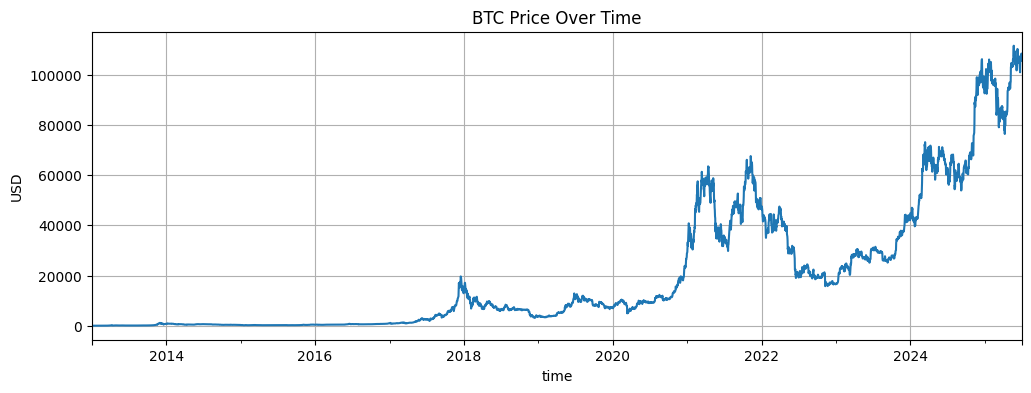


📈 This chart shows the long-term trend of Bitcoin price in USD. Significant
bull and bear markets are visible, reflecting high volatility and cyclicality
in crypto markets. It provides context for understanding when DCA strategies
may be more or less favorable.



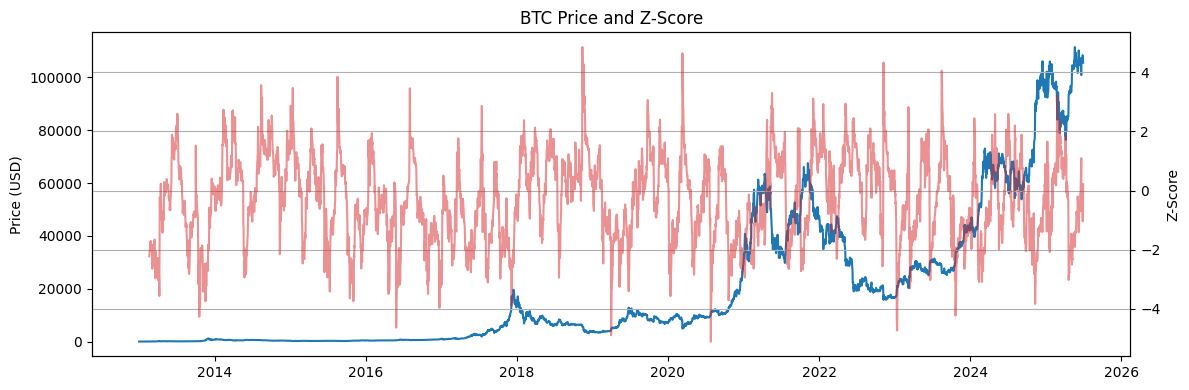


🔍 This dual-axis chart shows the BTC price alongside its Z-score,
which measures how far price deviates from its 50-day moving average in
standard deviation units. Negative z-scores indicate price dips below trend
and may present DCA opportunities.



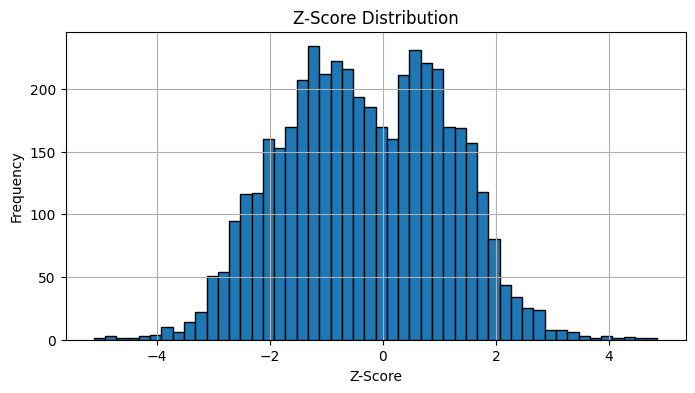


📊 The histogram shows the distribution of z-scores across the full dataset.
It helps assess how frequently BTC trades significantly above or below its trend.
A left-skewed distribution implies more negative deviations—potential opportunities
for strategic accumulation.

SPD (Uniform): 0.0020
SPD (Z-Score Based): 0.0018


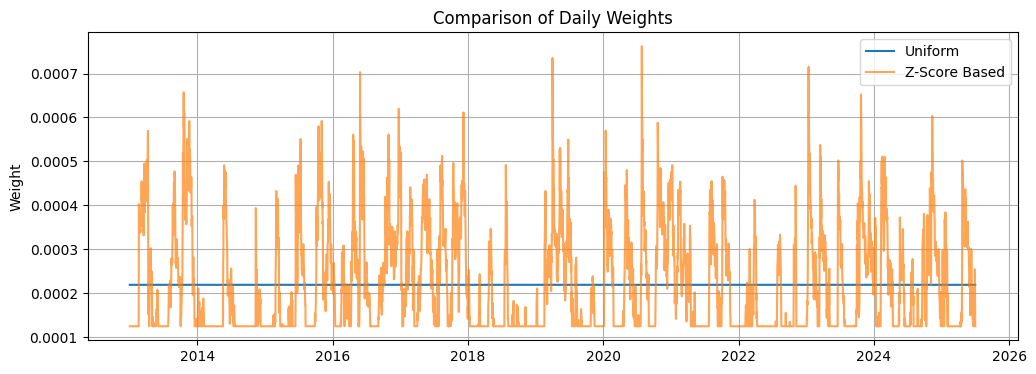


💰 This chart compares daily weights of uniform vs z-score-based DCA.
Z-score based weighting shifts more capital into periods where the asset
was significantly below trend, enabling higher SPD (sats per dollar) and
potential long-term returns.


Feature Correlations:
                 zscore  momentum_7d  volatility_14d
zscore          1.00000     -0.61574         0.05222
momentum_7d    -0.61574      1.00000         0.08251
volatility_14d  0.05222      0.08251         1.00000

📌 This correlation matrix helps identify how z-score relates to other features.
Moderate to high correlation could suggest redundant signals, while low correlation
indicates complementarity for multivariate strategies.



In [6]:
# 📊 EDA Notebook for BTC Accumulation

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
import requests
from io import BytesIO

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Load BTC price data from GitHub Parquet file
url = "https://raw.githubusercontent.com/TrilemmaFoundation/stacking-sats-tournament-mstr-2025/main/data/stacking_sats_data.parquet"
logging.info("Fetching BTC price data from GitHub...")
response = requests.get(url)
response.raise_for_status()

# Read and clean data
df = pd.read_parquet(BytesIO(response.content))
if df.index.name != 'time' and 'time' in df.columns:
    df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index).normalize()
df.index = df.index.tz_localize(None) if df.index.tz is not None else df.index
df = df.loc[~df.index.duplicated(keep='last')]
df = df.sort_index()

# 1. Price Trend Overview
plt.figure(figsize=(12, 4))
df['PriceUSD_coinmetrics'].plot(title="BTC Price Over Time")
plt.ylabel("USD")
plt.grid(True)
plt.show()

print("""
📈 This chart shows the long-term trend of Bitcoin price in USD. Significant
bull and bear markets are visible, reflecting high volatility and cyclicality
in crypto markets. It provides context for understanding when DCA strategies
may be more or less favorable.
""")

# 2. Z-Score Dynamics
window = 50
df['ma'] = df['PriceUSD_coinmetrics'].rolling(window).mean()
df['std'] = df['PriceUSD_coinmetrics'].rolling(window).std()
df['zscore'] = (df['ma'] - df['PriceUSD_coinmetrics']) / df['std']

# Plot Z-Score + Price
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(df.index, df['PriceUSD_coinmetrics'], label='Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df.index, df['zscore'], label='Z-Score', color='tab:red', alpha=0.5)
ax1.set_title("BTC Price and Z-Score")
ax1.set_ylabel("Price (USD)")
ax2.set_ylabel("Z-Score")
fig.tight_layout()
plt.grid(True)
plt.show()

print("""
🔍 This dual-axis chart shows the BTC price alongside its Z-score,
which measures how far price deviates from its 50-day moving average in
standard deviation units. Negative z-scores indicate price dips below trend
and may present DCA opportunities.
""")

# Z-Score Histogram
plt.figure(figsize=(8, 4))
df['zscore'].hist(bins=50, edgecolor='black')
plt.title("Z-Score Distribution")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print("""
📊 The histogram shows the distribution of z-scores across the full dataset.
It helps assess how frequently BTC trades significantly above or below its trend.
A left-skewed distribution implies more negative deviations—potential opportunities
for strategic accumulation.
""")

# 3. SPD and Weighting Impact (Illustrative)
df['uniform_weight'] = 1 / len(df)
df['z_weight'] = df['zscore'].apply(lambda z: 1 + abs(z) if z < 0 else 1)
df['z_weight'] /= df['z_weight'].sum()

df['btc_units_uniform'] = df['uniform_weight'] / df['PriceUSD_coinmetrics']
df['btc_units_z'] = df['z_weight'] / df['PriceUSD_coinmetrics']

spd_uniform = df['btc_units_uniform'].sum()
spd_zscore = df['btc_units_z'].sum()

print(f"SPD (Uniform): {spd_uniform:.4f}")
print(f"SPD (Z-Score Based): {spd_zscore:.4f}")

# Plot weights
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['uniform_weight'], label='Uniform')
plt.plot(df.index, df['z_weight'], label='Z-Score Based', alpha=0.7)
plt.title("Comparison of Daily Weights")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()

print("""
💰 This chart compares daily weights of uniform vs z-score-based DCA.
Z-score based weighting shifts more capital into periods where the asset
was significantly below trend, enabling higher SPD (sats per dollar) and
potential long-term returns.
""")

# 4. Feature Correlation Checks
df['momentum_7d'] = df['PriceUSD_coinmetrics'].pct_change(7)
df['volatility_14d'] = df['PriceUSD_coinmetrics'].pct_change().rolling(14).std()

corrs = df[['zscore', 'momentum_7d', 'volatility_14d']].corr()
print("\nFeature Correlations:")
print(corrs)

print("""
📌 This correlation matrix helps identify how z-score relates to other features.
Moderate to high correlation could suggest redundant signals, while low correlation
indicates complementarity for multivariate strategies.
""")

# 5. Conclusion (Markdown cell to be added in notebook)
# - Z-Score shows strong reversal opportunities
# - Momentum and volatility can be helpful but less consistent
